#Regression Project Dec 2021
##Predict Russian Real Estate Prices


In [ ]:
#import the useful libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # For train/test splits
from sklearn.neighbors import KNeighborsClassifier # The k-nearest neighbor classifier
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.pipeline import Pipeline # For setting up pipeline
# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV # For optimization
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
!pip install fast_ml

from fast_ml.model_development import train_valid_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 42 kB 741 kB/s 


#EDA
##Clean outliers in the data and add new calculated fetures

In [ ]:
MIN_PRICE = 0.002 #550000 rubel = 7463.50 USD
MAX_PRICE = 0.999 #58159753 rubel = 789227 USD
MIN_AREA = 0.005 #17 sm
MAX_AREA = 0.999 #270 sm
MIN_KITCHEN_AREA = 0.002
MAX_KITCHEN_AREA = 0.999 #53.2

In [ ]:
#https://www.kaggle.com/mrdaniilak/russia-real-estate-20182021
pathCSV = '/content/drive/MyDrive/Naya-Projects/Regression-project/all_v2.csv'

def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

set_display()

def clean_data(df) -> pd.DataFrame:
  df=df[df.price>0]
  #drop time col
  df.drop("time",axis=1,inplace=True)
  #date col to datetime
  df.date = pd.to_datetime(df.date)
  df.rooms = df.rooms.apply(lambda x : 1 if x == -1 else x)
  df.rooms = df.rooms.apply(lambda x : 2 if x == -2 else x)
  df = df[df.level<=df.levels]

  minPrice = df.loc[:,"price"].quantile(q=MIN_PRICE)
  maxPrice = df.loc[:,"price"].quantile(q=MAX_PRICE)
  df=df[df.price>=minPrice]
  df=df[df.price<=maxPrice]

  minArea = df.loc[:,"area"].quantile(q=MIN_AREA)
  maxArea = df.loc[:,"area"].quantile(q=MAX_AREA)
  df=df[df.area>=minArea]
  df=df[df.area<=maxArea]

  minKitchenArea = df.loc[:,"kitchen_area"].quantile(q=MIN_KITCHEN_AREA)
  maxKitchenArea = df.loc[:,"kitchen_area"].quantile(q=MAX_KITCHEN_AREA)
  df=df[df.kitchen_area>=minKitchenArea]
  df=df[df.kitchen_area<=maxKitchenArea]
  return df

def add_features(df) -> pd.DataFrame:
  df["level_ratio_to_levels"]= df.level/df.levels
  df["levels_to_top"]= df.levels-df.level
  df["room_area_ratio"]= round(df.area/df.rooms,0)  
  df['year'] = pd.DatetimeIndex(df['date']).year
  df['quarter'] = pd.PeriodIndex(df.date, freq='Q')
  #df = pd.get_dummies(df,columns=["rooms","region"])
  return df



##create transformer that filters outliers by quantile value

In [ ]:
class trnQuantileMinMax():
    def __init__(self, colName,minQ, maxQ):
        self.colName = colName
        self.minQ = minQ
        self.maxQ = maxQ
        
    def fit(self, df, y=None):
        # print(self.minQ)
        # print(self.maxQ)
        self.minVal = df.loc[:,self.colName].quantile(q=self.minQ)
        self.maxVal = df.loc[:,self.colName].quantile(q=self.maxQ)  
        return self
        
    def transform(self, df, y=None):
      return df.loc[(df.loc[:,self.colName]>=self.minVal) & (df.loc[:,self.colName]<=self.maxVal)]

In [ ]:
df = pd.read_csv(pathCSV)
df = clean_data(df)
df = add_features(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5421513 entries, 0 to 5477005
Columns: 101 entries, price to quarter_2021Q2
dtypes: float64(1), int64(2), uint8(98)
memory usage: 672.1 MB


In [ ]:
df.price[df.price<0]

Series([], Name: price, dtype: int64)

In [ ]:
df.head()

,price,area,level,region_3,region_69,region_81,region_821,region_1010,region_1491,region_1901,region_2072,region_2328,region_2359,region_2484,region_2528,region_2594,region_2604,region_2661,region_2722,region_2806,region_2814,region_2843,region_2860,region_2871,region_2880,region_2885,region_2900,region_2922,region_3019,region_3106,region_3153,region_3230,region_3446,region_3870,region_3991,region_4007,region_4086,region_4189,region_4240,region_4249,region_4374,region_4417,region_4695,region_4963,region_4982,region_5143,region_5178,region_5241,region_5282,region_5368,region_5520,region_5703,region_5736,region_5789,region_5794,region_5952,region_5993,region_6171,region_6309,region_6543,region_6817,region_6937,region_7121,region_7793,region_7873,region_7896,region_7929,region_8090,region_8509,region_8640,region_8894,region_9579,region_9648,region_9654,region_10160,region_10201,region_10582,region_11171,region_11416,region_11991,region_13098,region_13913,region_13919,region_14368,region_14880,region_16705,region_61888,quarter_2018Q1,quarter_2018Q2,quarter_2018Q3,quarter_2018Q4,quarter_2019Q1,quarter_2019Q2,quarter_2019Q3,quarter_2019Q4,quarter_2020Q1,quarter_2020Q2,quarter_2020Q3,quarter_2020Q4,quarter_2021Q1,quarter_2021Q2
0,6050000,82.6000,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8650000,69.1000,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4000000,66.0000,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1850000,38.0000,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5450000,60.0000,13,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
my_trnSetMinMax = trnQuantileMinMax("area",0.599,0.6)
my_trnSetMinMax.fit(df)
df2 = my_trnSetMinMax.transform(df)
print(len(df), len(df2))

0.599
0.6
5421513 10895


#Feature Selection


In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install basemap
!pip install https://github.com/matplotlib/basemap/archive/master.zip

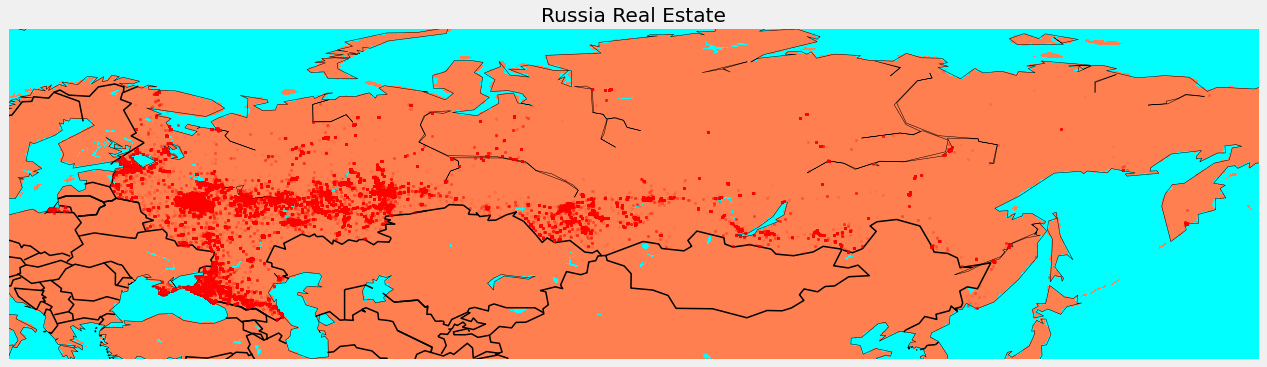

In [ ]:
from mpl_toolkits.basemap import Basemap
lat = df['geo_lat'].values
lon = df['geo_lon'].values

plt.figure(figsize=(20,15))

m = Basemap(projection="mill"
            ,llcrnrlat=lat.min()-5
            ,urcrnrlat=lat.max()+5
            ,llcrnrlon=lon.min()-5
            ,urcrnrlon=lon.max()+5
            ,resolution='c'
            ,epsg=4269)
m.drawlsmask(land_color='coral',ocean_color='aqua',lakes=True)
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=1.5) 


parallels = np.arange(0.,81,10.)
meridians = np.arange(0.,360.,10.)

m.plot(lon, lat, 'ro', markersize=1 ,alpha=.05)

plt.title("Russia Real Estate Sales")
plt.show()


In [ ]:
df.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,level_ratio_to_levels,levels_to_top,room_area_ratio
count,5421513.0000,5421513.0000,5421513.0000,5421513.0000,5421513.0000,5421513.0000,5421513.0000,5421513.0000,5421513.0000,5421513.0000,5421513.0000,5421513.0000,5421513.0000,5421513.0000
mean,4253677.7484,54.0319,53.2689,4316.3272,1.9464,6.2347,11.4316,1.8360,53.4675,10.5587,3.9649,0.5680,5.1969,31.5265
std,4623875.0357,4.6177,20.7531,3308.4085,1.0376,4.9596,6.5383,0.8711,22.2508,5.1626,4.5671,0.2896,4.9487,9.5953
min,400000.0000,41.4591,19.8902,3.0000,0.0000,1.0000,1.0000,1.0000,17.0000,1.0000,1.0000,0.0270,0.0000,2.0000
25%,1950000.0000,53.3747,37.7805,2661.0000,1.0000,2.0000,5.0000,1.0000,38.3000,7.0000,1.0000,0.3333,1.0000,24.0000
50%,2999000.0000,55.1658,43.1384,2922.0000,2.0000,5.0000,10.0000,2.0000,48.0200,9.8000,1.0000,0.5833,4.0000,30.0000
75%,4800000.0000,56.2223,65.6574,6171.0000,3.0000,9.0000,16.0000,2.0000,63.1000,12.7000,11.0000,0.8000,8.0000,37.0000
max,87000000.0000,71.9804,162.5361,61888.0000,5.0000,39.0000,39.0000,9.0000,270.0000,51.0000,11.0000,1.0000,37.0000,270.0000


## display price/quarter relation

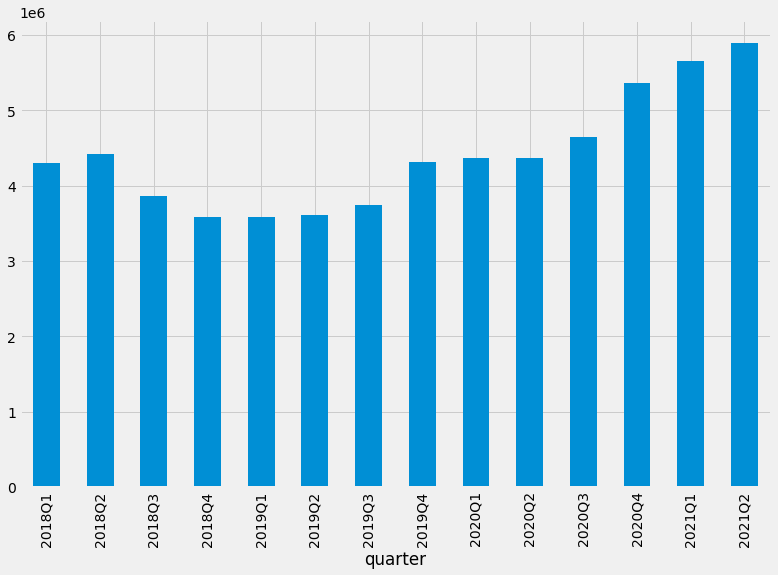

In [ ]:
df.groupby(["quarter"])["price"].mean().plot(kind="bar")

## display price/rooms relation

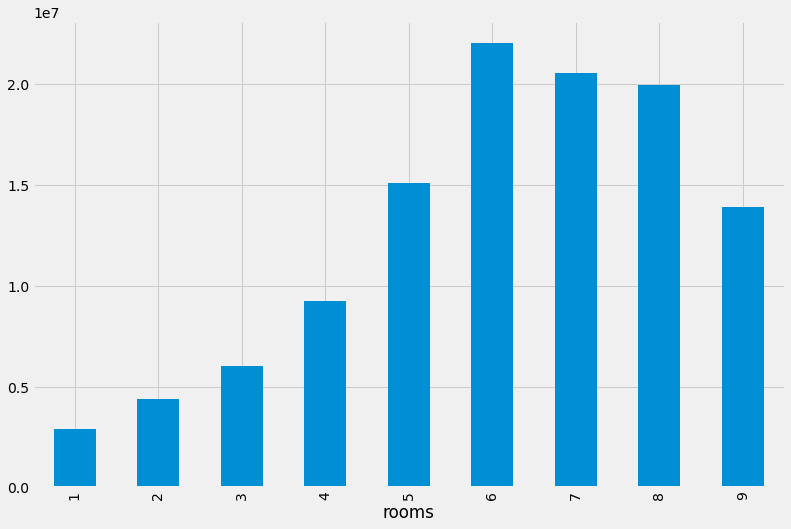

In [ ]:
df.groupby(["rooms"])["price"].mean().plot(kind="bar")

##How apartment level affect price
#Higher levels are prices higher

## display price/level relation

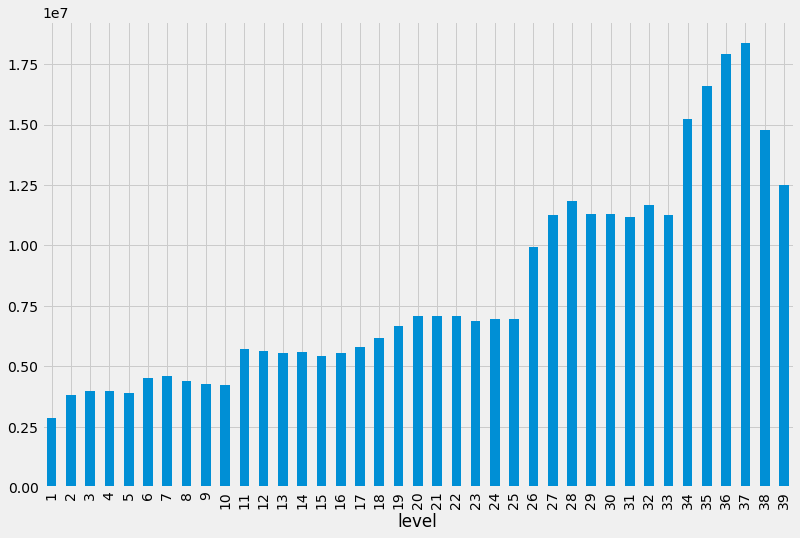

In [ ]:
df.groupby(["level"])["price"].mean().plot(kind="bar")

## How Levels to top affect price 
#Apparently closer to top is prices lower , why ???

## display price/level to top relation

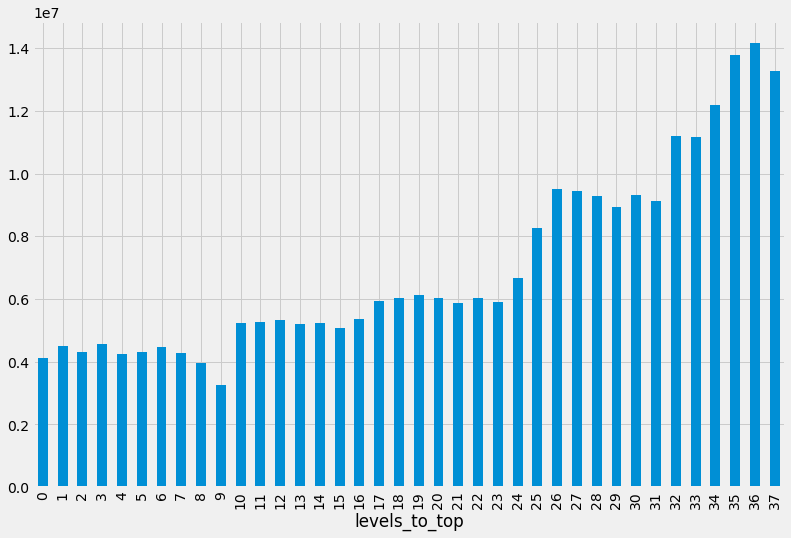

In [ ]:
df[df.object_type==11].groupby(["levels_to_top"])["price"].mean().plot(kind="bar")

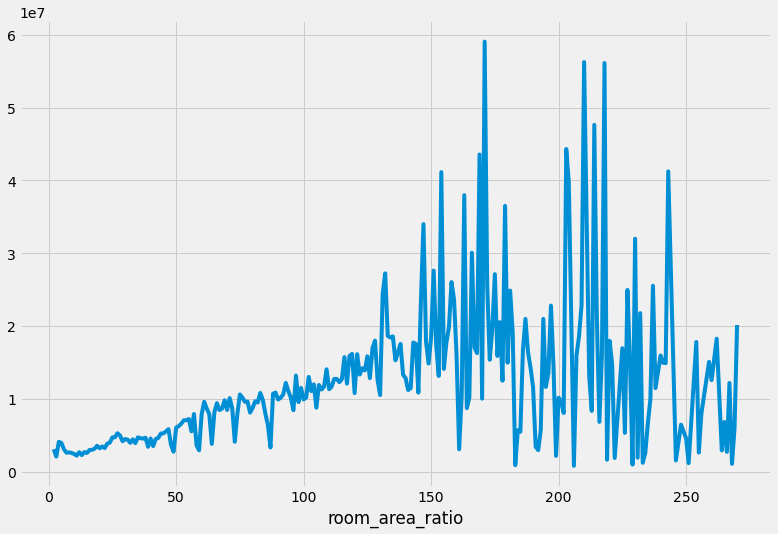

In [ ]:
df.groupby(["room_area_ratio"])["price"].mean().plot()

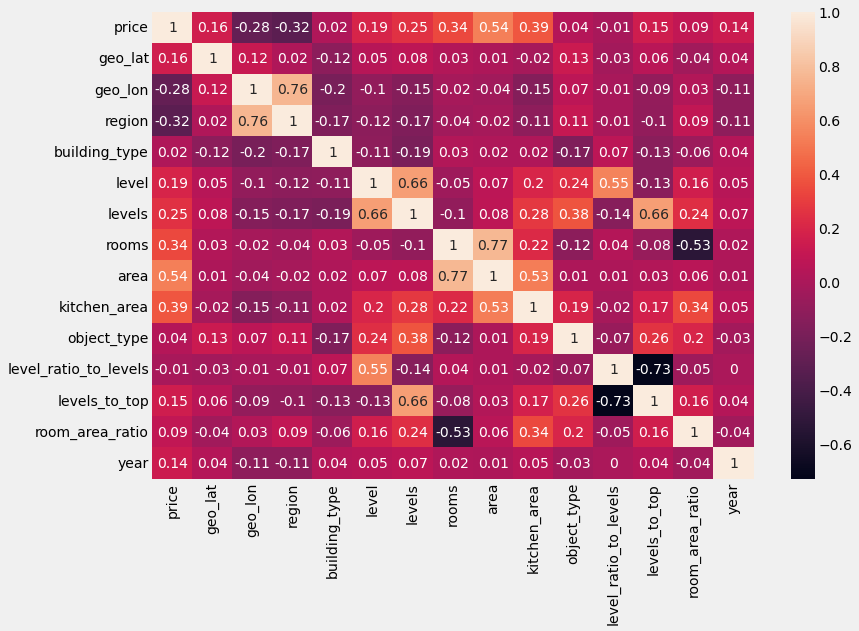

In [ ]:
correlation_matrix = df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True)


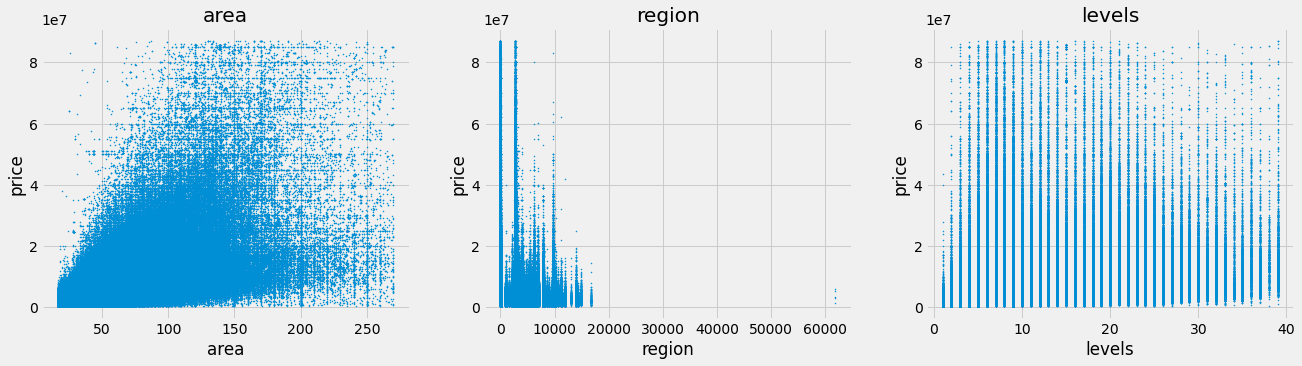

In [ ]:
plt.figure(figsize=(20, 5))

features=  ["area" , "region" , "levels"]
target = df['price']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df[col]
    y = target
    plt.scatter(x, y, marker='o',s=1)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price')

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))

y_valid_pred = lr.predict(X_valid)
print(np.sqrt( mean_squared_error(y_valid, y_valid_pred)))

2862461.943817127
2955368.0179398535


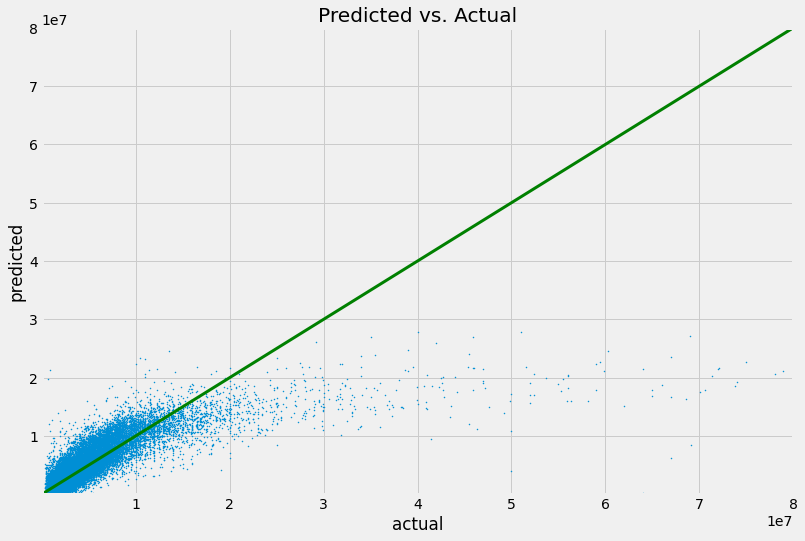

In [ ]:
prices = pd.DataFrame()
prices["actual"] = y_train.astype(int)
prices["predicted"] = y_train_pred.astype(int)

ax = prices.plot('actual', 'predicted', kind='scatter',
                 xlim=[1000, 80000000], ylim=[1000, 80000000],
                 title='Predicted vs. Actual',s=1)
ax.plot(np.linspace(1000, 80000000, 2), np.linspace(1000, 80000000, 2),
        linewidth=3, color='g')

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(min_samples_leaf=100)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
dt_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f"dt_rmse = {dt_rmse}")
for feature, importance in zip(X_train.columns, model.feature_importances_):
    if(importance>0):
      print(f'{feature:12}: {importance}')

## we have selected the feturs quarter, area , region , level as they are the features that influence the most 

In [ ]:
selected_features = ["price", "quarter", "area" , "region" , "level"]
df = df[selected_features]
df = pd.get_dummies(df,columns=["region", "quarter"])


In [ ]:
df_small_sample = df.sample(50000)

X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_small_sample, target = 'price', 
                                                                            train_size=0.7, valid_size=0.15, test_size=0.15,random_state=555)

RMSE on LinearRegression train data:  2971768.262183017


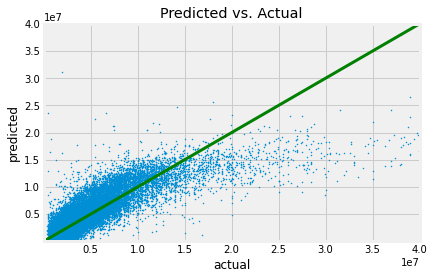

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.tree import DecisionTreeRegressor

pipe_lr = Pipeline([('scale', MinMaxScaler()), ('lr',LinearRegression())])
# fit the pipeline with the training data
pipe_lr.fit(X_train,y_train)
# predict target values on the training data
y_predicted = pipe_lr.predict(X_train)
print('RMSE on LinearRegression train data: ', mean_squared_error(y_train, y_predicted)**(0.5))

prices = pd.DataFrame()
prices["actual"] = y_train.astype(int)
prices["predicted"] = y_predicted.astype(int)

maxPrice=40000000
ax = prices.plot('actual', 'predicted', kind='scatter',
                 xlim=[1000, maxPrice], ylim=[1000, maxPrice],
                 title='Predicted vs. Actual',s=1)
ax.plot(np.linspace(1000, maxPrice, 2), np.linspace(1000, maxPrice, 2),
        linewidth=3, color='g')


## Perform model testing on 3 model types with different args. Using pipelines and Grid cross validation

In [ ]:
pipe_lr = Pipeline([('lr',LinearRegression())])

pipe_dt = Pipeline([('scale', MinMaxScaler()),('dt',DecisionTreeRegressor())])

pipe_knn = Pipeline([('scale', MinMaxScaler()),('knn',KNeighborsRegressor())])

grid_params_lr = [{}]
grid_params_dt = [{'dt__max_leaf_nodes': [10,20,30],
                   'dt__min_samples_leaf' : [100,500,1000]}]

grid_params_knn = [{'knn__n_neighbors': [10,20,30]}]

gs_lr = GridSearchCV(estimator=pipe_lr,
                     param_grid=grid_params_lr,
                     scoring = 'neg_root_mean_squared_error')

gs_dt = GridSearchCV(estimator=pipe_dt,
                     param_grid=grid_params_dt,
                     scoring = 'neg_root_mean_squared_error')

gs_knn = GridSearchCV(estimator=pipe_knn,
                     param_grid=grid_params_knn,
                     scoring = 'neg_root_mean_squared_error')

In [ ]:
from sklearn.metrics import accuracy_score
import sys

grids = [gs_lr,gs_dt, gs_knn]
grid_dict = {0:'Linear Regression', 1: 'Decision Tree Regressor', 2: 'K Neighbors Regressor'}
print('Performing model optimizations...')
best_acc = sys.maxsize
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])	
    # Fit grid search	
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training data accuracy
    print('Best training accuracy: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_valid)
    # Test data accuracy of model with best params
    print('Validator set accuracy score for best params: %.3f ' % np.sqrt(mean_squared_error(y_valid, y_pred)))
    # Track best (highest test accuracy) model
    if np.sqrt(mean_squared_error(y_valid, y_pred)) < best_acc:
      best_acc = np.sqrt(mean_squared_error(y_valid, y_pred))
      best_gs = gs
      best_clf = idx
print('\nRegrator with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: Linear Regression
Best params: {}
Best training accuracy: -2981210.294
Validator set accuracy score for best params: 2658138.597 

Estimator: Decision Tree Regressor
Best params: {'dt__max_leaf_nodes': 30, 'dt__min_samples_leaf': 100}
Best training accuracy: -2605235.909
Validator set accuracy score for best params: 2363776.473 

Estimator: K Neighbors Regressor
Best params: {'knn__n_neighbors': 10}
Best training accuracy: -2742980.114
Validator set accuracy score for best params: 2356247.352 

Regrator with best test set accuracy: K Neighbors Regressor
